In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [2]:
BATCH_SIZE = 10 
IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3
TRAIN_PATH = r"C:\Users\USER\Downloads\data-science-bowl-2018\stage1_train"
TEST_PATH = r"C:\Users\USER\Downloads\data-science-bowl-2018\stage1_test"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [4]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH +'/'+ id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


C:\Users\USER\AppData\Local\Temp/ipykernel_7872/53040673.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\USER\AppData\Local\Temp/ipykernel_7872/53040673.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: h

In [5]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH +'/'+ id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:03<00:00, 18.26it/s]

Done!


In [6]:
from keras.preprocessing import image

# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


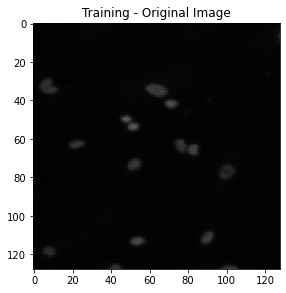

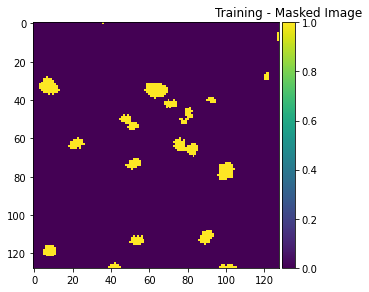

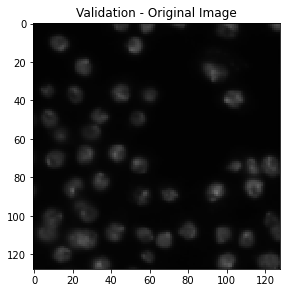

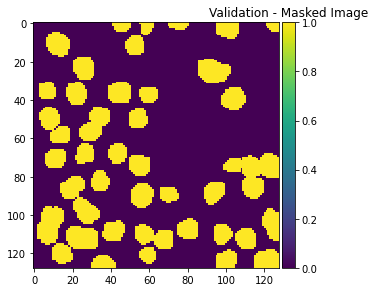

In [42]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.title("Training - Original Image")
plt.show()
imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.title("Training - Masked Image")
plt.show()
imshow(x_val.next()[0].astype(np.uint8))
plt.title("Validation - Original Image")
plt.show()
imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.title("Validation - Masked Image")
plt.show()

In [8]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [9]:
"""def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)"""

def iou(self,y_true,y_pred):
        y_true=tf.cast(y_true,tf.float32)
        y_pred=tf.cast(y_pred,tf.float32)
        
        def f(y_true,y_pred):
            intersection=(y_true*y_pred).sum()
            union=y_true.sum()+y_pred.sum()-intersection
            x=(intersection+1e-15)/(union+1e-15)
            x=x.astype(np.float32)
            return x
        
        return tf.numpy_function(f,[y_true,y_pred],tf.float32)

In [13]:
# The convolation block 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x


# The encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    
    return x, p


# The decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [14]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    modelUnet = Model(inputs=inputs, outputs=outputs, name="OriginalUNET")

    modelUnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

    return modelUnet

In [15]:
UNet = unet((128, 128, 3))
checkpointer = tf.keras.callbacks.ModelCheckpoint("modelUnet.h5", verbose=1, save_best_only=True)
callbacks=[
    checkpointer,
    tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = UNet.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=5, callbacks=callbacks)

Epoch 1/5
38/38 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8993
Epoch 1: val_loss improved from inf to 130.94720, saving model to modelUnet.h5
38/38 [==============================] - 360s 9s/step - loss: 0.3250 - accuracy: 0.8993 - val_loss: 130.9472 - val_accuracy: 0.1882
Epoch 2/5
38/38 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9459
Epoch 2: val_loss improved from 130.94720 to 111.06235, saving model to modelUnet.h5
38/38 [==============================] - 357s 9s/step - loss: 0.1901 - accuracy: 0.9459 - val_loss: 111.0623 - val_accuracy: 0.2228
Epoch 3/5
38/38 [==============================] - ETA: 0s - loss: 0.1531 - accuracy: 0.9514
Epoch 3: val_loss improved from 111.06235 to 2.08649, saving model to modelUnet.h5
38/38 [==============================] - 371s 10s/step - loss: 0.1531 - accuracy: 0.9514 - val_loss: 2.0865 - val_accuracy: 0.8794
Epoch 4/5
38/38 [==============================] - ETA: 0s - loss: 0.1375 - acc

In [43]:
UNet.summary()

Model: "OriginalUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d_38[0][0]']              
 alization)                     )                                                      

 conv2d_47 (Conv2D)             (None, 8, 8, 1024)   9438208     ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_47[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 8, 8, 1024)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose_8 (Conv2DTran  (None, 16, 16, 512)  2097664    ['activation_9[0][0]']           
 spose)                                                                                           
                                                                                                  
 concatena

                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 128, 128, 64  256        ['conv2d_55[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_17 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 128, 128, 1)  65          ['activation_17[0][0]']          
                                                                                                  
Total para

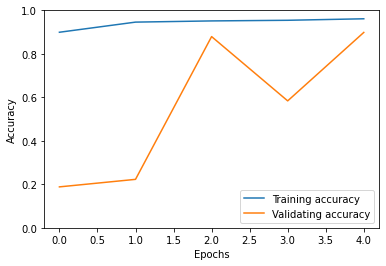

In [16]:
plt.plot(results.history['accuracy'], label='Training accuracy')
plt.plot(results.history['val_accuracy'], label='Validating accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc = 'lower right')

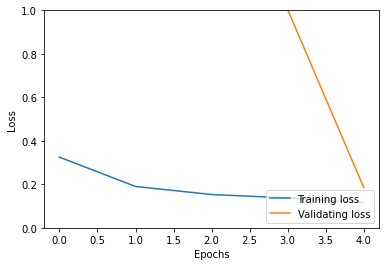

In [44]:
plt.plot(results.history['loss'], label='Training loss')
plt.plot(results.history['val_loss'], label='Validating loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.legend(loc = 'lower right')

In [18]:
model = load_model('modelUnet.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 11s 3s/step


In [35]:
from sklearn.metrics import accuracy_score

TRAINING IMAGES

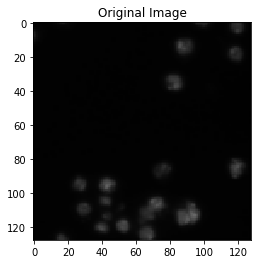

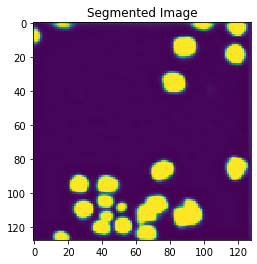

In [39]:
img = X_train[:int(X_train.shape[0]*0.9)][0]
plt.imshow(img, interpolation='nearest')
plt.title("Original Image")
plt.show()
img = preds_train[0]
plt.imshow(img, interpolation='nearest')
plt.title("Segmented Image")
plt.show()

VALIDATION IMAGES

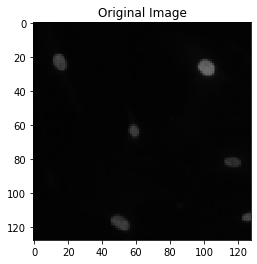

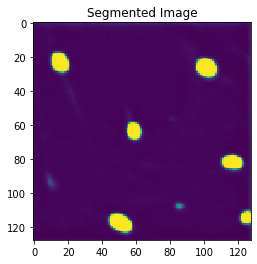

In [33]:
img = X_train[int(X_train.shape[0]*0.9):][0]
plt.imshow(img, interpolation='nearest')
plt.title("Original Image")
plt.show()
img = preds_val[0]
plt.imshow(img, interpolation='nearest')
plt.title("Segmented Image")
plt.show()

TESTING IMAGES

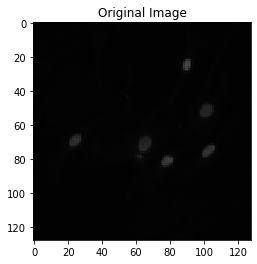

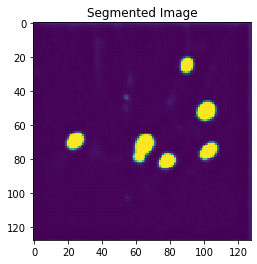

In [34]:
img = X_test[0]
plt.imshow(img, interpolation='nearest')
plt.title("Original Image")
plt.show()
img = preds_test[0]
plt.imshow(img, interpolation='nearest')
plt.title("Segmented Image")
plt.show()